
2025년 1월 수출량 예측:
예측 수출량: 875,087


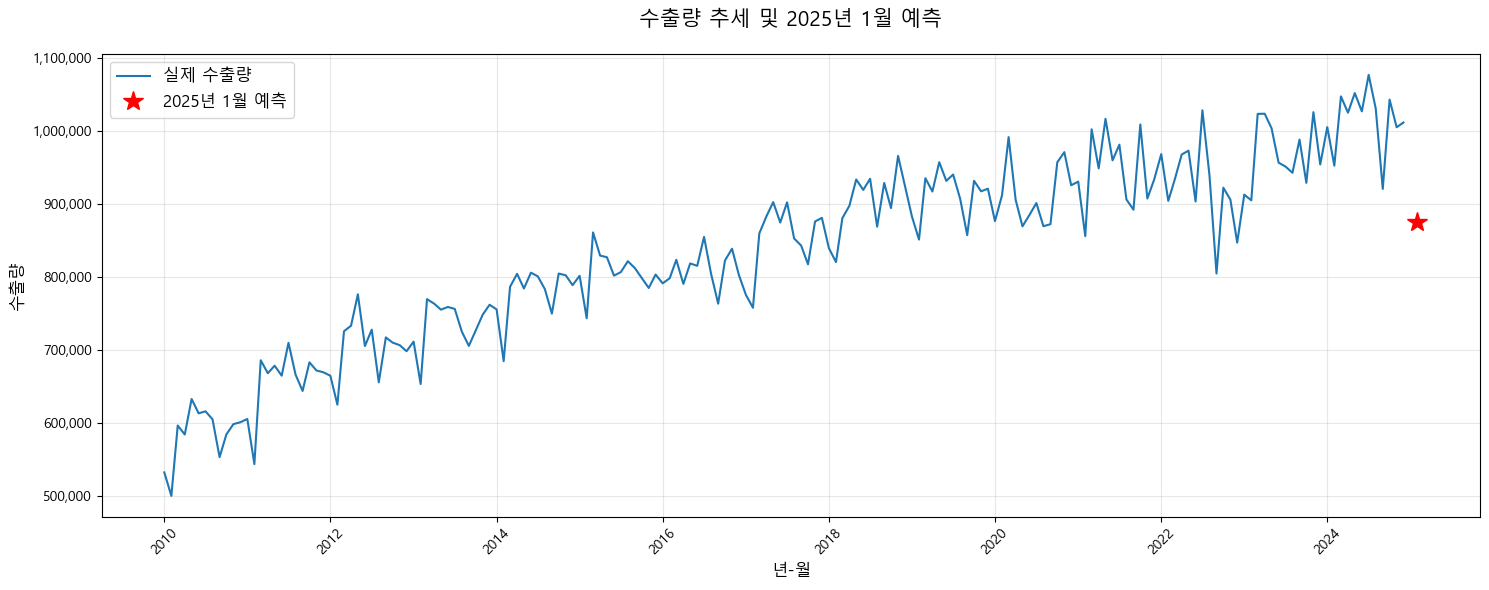

<Figure size 1000x600 with 0 Axes>

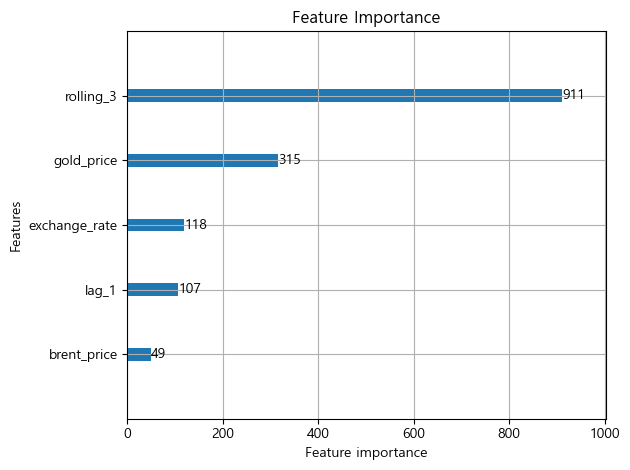

In [4]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')


# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐 방지
plt.rc('axes', unicode_minus=False)

# 데이터 로드
df = pd.read_csv('data_integ_1.csv', parse_dates=['date'])  # 데이터 통합본 넣기 // 감성지수 데이터도 포함
df.set_index('date', inplace=True)

# Lag 및 파생변수 생성
# 이전 수출량 데이터를 반영해 시계열의 연속성과 패턴을 학습하도록 lag 및 파생 변수 생성
df['lag_1'] = df['export'].shift(1) # 한 달 전 수출량
df['lag_2'] = df['export'].shift(2) # 두 달 전 수출량
df['rolling_3'] = df['export'].rolling(window=3).mean().shift(1) # 이전 3개월간 수출량 평균 (직전 월까지)
df['diff_1'] = df['export'].diff(1).shift(1) # 직전 월 대비 수출량 차이 (변동성 반영)

# 타겟 변수와 피쳐 분리
X = df.drop(columns=['export'])
y = df['export']

# 전체 데이터를 학습에 사용 // 분할 Test,Train 분할 X
train_data = lgb.Dataset(data=X, label=y)

# 모델 파라미터 설정
params = {
    'max_depth': 3,
    'learning_rate': 0.001,
    'objective': 'regression',
    'metric': 'rmse',
    'verbose': -1
}
num_rounds = 300

# LightGBM 모델 학습 (전체 데이터 사용)
model = lgb.train(params, train_data, num_boost_round=num_rounds)

# 2025년 1월 예측을 위한 데이터 준비
# 2024년 12월의 데이터를 기반으로 2025년 1월의 feature 데이터 생성
last_data = X.iloc[-1].copy()  # 2024년 12월 경제지표
last_export = y.iloc[-1]  # 2024년 12월 수출량

# 2025년 1월의 feature 데이터 업데이트
future_features = pd.DataFrame([last_data])
future_features.index = pd.date_range(start=X.index[-1], periods=2, freq='M')[1:] # 2025년 1월 날짜 설정

# lag 변수들 업데이트
future_features['lag_1'] = last_export  # 2024년 12월 수출량
future_features['lag_2'] = y.iloc[-2]   # 2024년 11월 수출량
future_features['rolling_3'] = y.iloc[-3:].mean()  # 최근 3개월 평균
future_features['diff_1'] = last_export - y.iloc[-2]  # 직전 월 대비 변화량

# 2025년 1월 수출량 예측
prediction_2025_01 = model.predict(future_features)[0]

print("\n2025년 1월 수출량 예측:")
print(f"예측 수출량: {prediction_2025_01:,.0f}")

# 과거 데이터와 예측값 시각화
plt.figure(figsize=(15, 6))

# 과거 실제 수출량
plt.plot(y.index, y, linestyle='-', label='실제 수출량', color='#1f77b4')

# 2025년 1월 예측값
plt.plot(future_features.index, [prediction_2025_01], marker='*', 
         markersize=15, linestyle='none', label='2025년 1월 예측', color='red')

# 그래프 스타일링
plt.title('수출량 추세 및 2025년 1월 예측', fontsize=15, pad=20)
plt.xlabel('년-월', fontsize=12)
plt.ylabel('수출량', fontsize=12)
plt.legend(prop={'size': 12})
plt.grid(True, alpha=0.3)

# x축 설정
all_dates = pd.concat([y, pd.Series([prediction_2025_01], index=future_features.index)])
plt.xticks(rotation=45)

# y축 포맷팅 (천 단위 쉼표)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))

plt.tight_layout()
plt.show()

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
lgb.plot_importance(model, importance_type='split')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()